In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class GE_Thyroid_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        image_type = self.df["image_type"][idx]

        if image_type == "train":
            from_folder = "../ge_data/train"
        else:
            from_folder = "../ge_data/test"

        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()

        return image_tensor, mask_tensor, mask_name, image_type

In [46]:
image_size = 128
batch_size = 128
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor

train_dataset = GE_Thyroid_Dataset("../ge_data/train_csv_for_finetune(1).csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = GE_Thyroid_Dataset("../ge_data/test_csv_for_finetune_all.csv", transform = test_augmentation, image_size = image_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

image, mask, mask_name, image_type = next(iter(train_dataloader))

In [47]:
print(len(train_dataset), len(test_dataset))

565 112


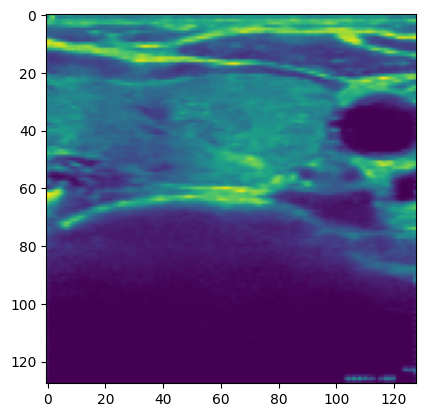

In [48]:
plt.imshow(image[10][0])

In [49]:

# inference_name = "hybrid_v3_baseline"

# model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
# checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# loss_fn = StructureLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
# lr = 0.01
# model.to("cuda")
# image = image.to("cuda")
# mask = mask.to("cuda")
# for epoch in range(200):
#     outputs = model(image)
        
#     output = outputs[:, 0:1, :, :]
    
    
#     loss = loss_fn(output, mask)

#     IOU = IOU_score(output, mask)

#     dice_loss = DiceLoss()
#     DICE = 1 - dice_loss(output, mask)

    
#     # Backward and optimize
#     optimizer.zero_grad()   # clear previous gradients
#     loss.backward()         # compute gradients
#     optimizer.step()        # update weights
#     print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, IOU: {IOU.item():.4f}, DICE: {DICE.item()}")

In [50]:
def train(dataloader, model, optimizer, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, mask_name, image_type in tqdm(dataloader):
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        output = outputs[:, 0:1, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()
        # count+=1
        # if count==5:
        #     break
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    
    total_IOU = 0
    
    total_DICE = 0

    model.eval()
    model.to(device)
    for image, mask, mask_name, image_type in tqdm(dataloader):
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        
        output = outputs[:, 0:1, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)
    

        total_loss += loss.item()
        
        total_IOU += IOU.item()
        
        total_DICE += DICE.item()
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


    

In [51]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.01, epochs : 200, batch size : 128


In [52]:

inference_name = "hybrid_v3_baseline"

model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

<All keys matched successfully>

In [53]:
# freeze encoder
for param in model.backbone.parameters():
    param.requires_grad = False

In [54]:
# loss_fn = DiceLoss()
loss_fn = StructureLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [56]:
epochs = 200
lr = 0.01
project = "thyroid_ge_finetune"
name = "hybrid_model_baseline(1)_freeze_encoder"
# name = "test"
wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

In [57]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train = train(train_dataloader, model, optimizer, loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/{name}"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
if not os.path.exists(folder):
    os.mkdir(folder)
torch.save(checkpoint, f"models/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


train loss : 1.2676745653152466, train IOU : 0.2074780397117138, train DICE : 0.26806256771087644


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.6772006154060364, val IOU : 0.45797446370124817, val DICE : 0.6111239194869995
epoch : 1


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.6360912919044495, train IOU : 0.4666443645954132, train DICE : 0.5764692544937133


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.6329243183135986, val IOU : 0.5022005438804626, val DICE : 0.6623436808586121
epoch : 2


100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


train loss : 0.49920437932014466, train IOU : 0.6029454708099365, train DICE : 0.7211269974708557


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4459439218044281, val IOU : 0.6931650042533875, val DICE : 0.8150655627250671
epoch : 3


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.47795053720474245, train IOU : 0.6133184432983398, train DICE : 0.748943817615509


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4483742117881775, val IOU : 0.6509735584259033, val DICE : 0.7971226572990417
epoch : 4


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.4512642562389374, train IOU : 0.6277923583984375, train DICE : 0.7633776068687439


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4360993504524231, val IOU : 0.6768894791603088, val DICE : 0.8094417452812195
epoch : 5


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.4362883925437927, train IOU : 0.633958899974823, train DICE : 0.7689531207084656


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.44296255707740784, val IOU : 0.7335667014122009, val DICE : 0.8175414800643921
epoch : 6


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.4295760452747345, train IOU : 0.6589945435523987, train DICE : 0.7824532985687256


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4357031583786011, val IOU : 0.6804131865501404, val DICE : 0.8080723881721497
epoch : 7


100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


train loss : 0.423573499917984, train IOU : 0.6385520696640015, train DICE : 0.7840957045555115


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4434763193130493, val IOU : 0.7331202626228333, val DICE : 0.8148037195205688
epoch : 8


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.41110754013061523, train IOU : 0.6638007760047913, train DICE : 0.7924353837966919


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.44650357961654663, val IOU : 0.6966716647148132, val DICE : 0.8074685335159302
epoch : 9


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.4087185263633728, train IOU : 0.6779932856559754, train DICE : 0.8004069209098816


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4438701868057251, val IOU : 0.6832796335220337, val DICE : 0.8006395101547241
epoch : 10


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.39141085743904114, train IOU : 0.6544479489326477, train DICE : 0.7897566795349121


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.448572039604187, val IOU : 0.7210429310798645, val DICE : 0.8000795245170593
epoch : 11


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.3764642238616943, train IOU : 0.7013113856315613, train DICE : 0.8087135672569274


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.45299845933914185, val IOU : 0.7130105495452881, val DICE : 0.7937656044960022
epoch : 12


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.3552871882915497, train IOU : 0.7152239322662354, train DICE : 0.8092611193656921


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.46862268447875977, val IOU : 0.7052963376045227, val DICE : 0.7874184250831604
epoch : 13


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.33466548323631284, train IOU : 0.7174400568008423, train DICE : 0.813073456287384


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4627785086631775, val IOU : 0.7214405536651611, val DICE : 0.7845612168312073
epoch : 14


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.3212511897087097, train IOU : 0.733693516254425, train DICE : 0.8257336854934693


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4579439163208008, val IOU : 0.7178674936294556, val DICE : 0.7778602242469788
epoch : 15


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.3017947912216187, train IOU : 0.7435448169708252, train DICE : 0.8278621912002564


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4589506685733795, val IOU : 0.7137438058853149, val DICE : 0.7702561616897583
epoch : 16


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.29043378233909606, train IOU : 0.743061637878418, train DICE : 0.831370735168457


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4894495904445648, val IOU : 0.7087851166725159, val DICE : 0.7674983143806458
epoch : 17


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.28156481981277465, train IOU : 0.7528522491455079, train DICE : 0.8306190609931946


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4718972146511078, val IOU : 0.708668053150177, val DICE : 0.7650780081748962
epoch : 18


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.2571106791496277, train IOU : 0.7781057834625245, train DICE : 0.8449645876884461


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4778202176094055, val IOU : 0.7042033672332764, val DICE : 0.7633050084114075
epoch : 19


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.25165793001651765, train IOU : 0.7716752767562867, train DICE : 0.845923638343811


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4835374355316162, val IOU : 0.6991150975227356, val DICE : 0.7656864523887634
epoch : 20


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.24283140599727632, train IOU : 0.783022654056549, train DICE : 0.8538610577583313


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.47091779112815857, val IOU : 0.7059852480888367, val DICE : 0.7726371884346008
epoch : 21


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.2325439840555191, train IOU : 0.7923837184906006, train DICE : 0.8594794988632202


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.46783965826034546, val IOU : 0.7141161561012268, val DICE : 0.7835558652877808
epoch : 22


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.22070474922657013, train IOU : 0.7972431063652039, train DICE : 0.8671641945838928


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4954417049884796, val IOU : 0.7020910978317261, val DICE : 0.7693762183189392
epoch : 23


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.2234100103378296, train IOU : 0.7994543313980103, train DICE : 0.8653161764144898


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.45933860540390015, val IOU : 0.7124849557876587, val DICE : 0.7811093330383301
epoch : 24


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.2153685748577118, train IOU : 0.8029976725578308, train DICE : 0.8680659413337708


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4500008225440979, val IOU : 0.715244710445404, val DICE : 0.7825167179107666
epoch : 25


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.20649711191654205, train IOU : 0.8206305503845215, train DICE : 0.8756576657295227


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4230506718158722, val IOU : 0.7308878302574158, val DICE : 0.7966449856758118
epoch : 26


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.20445199310779572, train IOU : 0.8146002292633057, train DICE : 0.8778720378875733


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.4561644196510315, val IOU : 0.7152377963066101, val DICE : 0.7818318009376526
epoch : 27


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.1970515191555023, train IOU : 0.8245341539382934, train DICE : 0.8819628715515136


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.49250340461730957, val IOU : 0.6987563967704773, val DICE : 0.7683160901069641
epoch : 28


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.1913287341594696, train IOU : 0.8239329934120179, train DICE : 0.8843292117118835


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.5138647556304932, val IOU : 0.6923542618751526, val DICE : 0.7651383280754089
epoch : 29


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.18396917581558228, train IOU : 0.8375260949134826, train DICE : 0.8909979104995728


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.48645341396331787, val IOU : 0.7059639096260071, val DICE : 0.7755047082901001
epoch : 30


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.18030319213867188, train IOU : 0.834535276889801, train DICE : 0.8908038020133973


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.48075583577156067, val IOU : 0.7069669961929321, val DICE : 0.7747182846069336
epoch : 31


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.18197741806507112, train IOU : 0.8413812518119812, train DICE : 0.8914199709892273


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.45899084210395813, val IOU : 0.7136090397834778, val DICE : 0.7882810831069946
epoch : 32


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.18039319515228272, train IOU : 0.8390947461128235, train DICE : 0.8943494558334351


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4229000508785248, val IOU : 0.720464289188385, val DICE : 0.799223780632019
epoch : 33


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.17130266427993773, train IOU : 0.8440042495727539, train DICE : 0.8951897263526917


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4836443066596985, val IOU : 0.7054281830787659, val DICE : 0.7766530513763428
epoch : 34


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.16247848868370057, train IOU : 0.8504384636878968, train DICE : 0.9022523164749146


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4655550718307495, val IOU : 0.7144105434417725, val DICE : 0.7864258289337158
epoch : 35


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.16084185242652893, train IOU : 0.8554732441902161, train DICE : 0.9050158858299255


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.4368024170398712, val IOU : 0.7214319705963135, val DICE : 0.7925292253494263
epoch : 36


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.15834319591522217, train IOU : 0.8588993430137635, train DICE : 0.9057097434997559


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.42927369475364685, val IOU : 0.712530791759491, val DICE : 0.7940402626991272
epoch : 37


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.159684482216835, train IOU : 0.8564884066581726, train DICE : 0.9067211985588074


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.463885098695755, val IOU : 0.7155759334564209, val DICE : 0.7871093153953552
epoch : 38


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.15549054145812988, train IOU : 0.8589205622673035, train DICE : 0.907061243057251


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.47093063592910767, val IOU : 0.7077711820602417, val DICE : 0.7785088419914246
epoch : 39


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.1499853551387787, train IOU : 0.861798894405365, train DICE : 0.9123640537261963


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.44290250539779663, val IOU : 0.7202070355415344, val DICE : 0.791700541973114
epoch : 40


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.14596087634563445, train IOU : 0.8665621519088745, train DICE : 0.912864601612091


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.5115438103675842, val IOU : 0.6996174454689026, val DICE : 0.7712641954421997
epoch : 41


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.14443133175373077, train IOU : 0.865105128288269, train DICE : 0.9142152547836304


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5280476212501526, val IOU : 0.6917417049407959, val DICE : 0.762090802192688
epoch : 42


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.1532100558280945, train IOU : 0.8611598610877991, train DICE : 0.9107650756835938


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.732227623462677, val IOU : 0.6135372519493103, val DICE : 0.692176342010498
epoch : 43


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.160829621553421, train IOU : 0.8610511422157288, train DICE : 0.9088177561759949


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5027796626091003, val IOU : 0.6863808035850525, val DICE : 0.7534350752830505
epoch : 44


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.14450705349445342, train IOU : 0.8700499773025513, train DICE : 0.9141097664833069


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4777613580226898, val IOU : 0.6978641748428345, val DICE : 0.7809420824050903
epoch : 45


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.1388015478849411, train IOU : 0.8729813456535339, train DICE : 0.9173662543296814


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.47884589433670044, val IOU : 0.6999422311782837, val DICE : 0.7707919478416443
epoch : 46


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.13829282224178313, train IOU : 0.8707645177841187, train DICE : 0.9186679363250733


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.46887725591659546, val IOU : 0.703637957572937, val DICE : 0.7767193913459778
epoch : 47


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.13894393146038056, train IOU : 0.8779358983039856, train DICE : 0.9195576906204224


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.45126548409461975, val IOU : 0.7109825611114502, val DICE : 0.786346971988678
epoch : 48


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.13650286793708802, train IOU : 0.8777780532836914, train DICE : 0.9211014986038208


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4430375397205353, val IOU : 0.7025162577629089, val DICE : 0.7826763987541199
epoch : 49


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.13968887478113173, train IOU : 0.8763570666313172, train DICE : 0.9219694018363953


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5509470701217651, val IOU : 0.6826225519180298, val DICE : 0.7490347623825073
epoch : 50


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.13082220554351806, train IOU : 0.8778826832771301, train DICE : 0.9234975457191468


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5574301481246948, val IOU : 0.663516640663147, val DICE : 0.7300838828086853
epoch : 51


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.1304655432701111, train IOU : 0.8810017228126525, train DICE : 0.9241989612579345


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5119400024414062, val IOU : 0.7025490403175354, val DICE : 0.779214084148407
epoch : 52


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.12431257218122482, train IOU : 0.8866539597511292, train DICE : 0.927974796295166


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.47816383838653564, val IOU : 0.705647349357605, val DICE : 0.7764988541603088
epoch : 53


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.12256085425615311, train IOU : 0.8878948330879212, train DICE : 0.9291723132133484


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.4719400405883789, val IOU : 0.7103201746940613, val DICE : 0.7856853008270264
epoch : 54


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.12234454452991486, train IOU : 0.8873151540756226, train DICE : 0.930165696144104


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.49685004353523254, val IOU : 0.6935089230537415, val DICE : 0.7649052143096924
epoch : 55


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.11934767812490463, train IOU : 0.8921451926231384, train DICE : 0.9313493847846985


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


val loss : 0.5391281843185425, val IOU : 0.6855894327163696, val DICE : 0.7612080574035645
epoch : 56


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.11657271534204483, train IOU : 0.8953072428703308, train DICE : 0.9336323380470276


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5028133392333984, val IOU : 0.6957777142524719, val DICE : 0.7689827084541321
epoch : 57


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.11405374258756637, train IOU : 0.8965667724609375, train DICE : 0.9343693971633911


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.47586745023727417, val IOU : 0.7078157067298889, val DICE : 0.782791793346405
epoch : 58


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.11099144369363785, train IOU : 0.8985262513160706, train DICE : 0.9364900350570678


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.529887855052948, val IOU : 0.6852608323097229, val DICE : 0.7602128386497498
epoch : 59


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.10786289125680923, train IOU : 0.8993332147598266, train DICE : 0.9374410033226013


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5430299043655396, val IOU : 0.6810194253921509, val DICE : 0.7522404789924622
epoch : 60


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.1086466670036316, train IOU : 0.9008791208267212, train DICE : 0.936762022972107


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5321238040924072, val IOU : 0.6866209506988525, val DICE : 0.7631292939186096
epoch : 61


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.10565942674875259, train IOU : 0.9066232323646546, train DICE : 0.9402684688568115


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5054258704185486, val IOU : 0.6970220804214478, val DICE : 0.7722632884979248
epoch : 62


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.10411894023418426, train IOU : 0.9068677186965942, train DICE : 0.9411065816879273


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5082234144210815, val IOU : 0.6967254877090454, val DICE : 0.773891031742096
epoch : 63


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.10138537883758544, train IOU : 0.9063218235969543, train DICE : 0.9414154767990113


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.5643653869628906, val IOU : 0.6780219674110413, val DICE : 0.7537076473236084
epoch : 64


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.10209331214427948, train IOU : 0.905615758895874, train DICE : 0.940973424911499


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5577715635299683, val IOU : 0.6818336248397827, val DICE : 0.7582269906997681
epoch : 65


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.10296493470668792, train IOU : 0.906222653388977, train DICE : 0.9412694096565246


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.553338348865509, val IOU : 0.6839079260826111, val DICE : 0.7593050599098206
epoch : 66


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.10241981744766235, train IOU : 0.9078481554985046, train DICE : 0.9424229860305786


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.533992350101471, val IOU : 0.6874172687530518, val DICE : 0.7666710615158081
epoch : 67


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.09675226658582688, train IOU : 0.9116204857826233, train DICE : 0.9444222688674927


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5339745283126831, val IOU : 0.6886714100837708, val DICE : 0.7648189067840576
epoch : 68


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.09703579246997833, train IOU : 0.909099006652832, train DICE : 0.9441773295402527


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5593738555908203, val IOU : 0.6869024634361267, val DICE : 0.7644935250282288
epoch : 69


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.09699545949697494, train IOU : 0.91232328414917, train DICE : 0.9453841805458069


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5257981419563293, val IOU : 0.6925753355026245, val DICE : 0.7702634334564209
epoch : 70


100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


train loss : 0.09926440119743347, train IOU : 0.9068226218223572, train DICE : 0.9422757506370545


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


val loss : 0.5501003265380859, val IOU : 0.6861631870269775, val DICE : 0.7628737092018127
epoch : 71


100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


train loss : 0.09566753804683685, train IOU : 0.9179110288619995, train DICE : 0.947289764881134


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.4943767189979553, val IOU : 0.7051430940628052, val DICE : 0.7834121584892273
epoch : 72


100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


train loss : 0.09484158754348755, train IOU : 0.9113561987876893, train DICE : 0.9458324909210205


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5234620571136475, val IOU : 0.696674644947052, val DICE : 0.7735727429389954
epoch : 73


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.09147714525461197, train IOU : 0.9163155078887939, train DICE : 0.947557556629181


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5608426332473755, val IOU : 0.6859782338142395, val DICE : 0.7678329348564148
epoch : 74


100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


train loss : 0.09018072634935378, train IOU : 0.9217161417007447, train DICE : 0.9502248525619507


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5136790871620178, val IOU : 0.6948729157447815, val DICE : 0.7742226719856262
epoch : 75


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.09081382751464843, train IOU : 0.9152348756790161, train DICE : 0.9477604866027832


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5371547937393188, val IOU : 0.6936703324317932, val DICE : 0.7693375945091248
epoch : 76


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.08888107389211655, train IOU : 0.9215266585350037, train DICE : 0.950597059726715


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5061578154563904, val IOU : 0.7001475691795349, val DICE : 0.7806798815727234
epoch : 77


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.09142703711986541, train IOU : 0.9155205011367797, train DICE : 0.9485195517539978


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5093131065368652, val IOU : 0.6989505887031555, val DICE : 0.7781035304069519
epoch : 78


100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


train loss : 0.08652013540267944, train IOU : 0.9195391535758972, train DICE : 0.95032240152359


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.583031415939331, val IOU : 0.677366316318512, val DICE : 0.7627469897270203
epoch : 79


100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


train loss : 0.08696168661117554, train IOU : 0.9211196541786194, train DICE : 0.9512306213378906


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5483640432357788, val IOU : 0.6914671659469604, val DICE : 0.7691211104393005
epoch : 80


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.0858174741268158, train IOU : 0.9248969912528991, train DICE : 0.952995502948761


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5292716026306152, val IOU : 0.6880205869674683, val DICE : 0.7738003730773926
epoch : 81


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.08603232502937316, train IOU : 0.9217801570892334, train DICE : 0.9517892599105835


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5293548703193665, val IOU : 0.6988230347633362, val DICE : 0.7777289748191833
epoch : 82


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


train loss : 0.08379116952419281, train IOU : 0.9244335889816284, train DICE : 0.9532435536384583


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5467162132263184, val IOU : 0.6865538954734802, val DICE : 0.7675031423568726
epoch : 83


100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


train loss : 0.08363105803728103, train IOU : 0.9249258875846863, train DICE : 0.953551197052002


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5592286586761475, val IOU : 0.6875994801521301, val DICE : 0.7706578373908997
epoch : 84


100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


train loss : 0.0849375382065773, train IOU : 0.9227375388145447, train DICE : 0.9524585604667664


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5634680986404419, val IOU : 0.6750949025154114, val DICE : 0.7623963952064514
epoch : 85


100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


train loss : 0.08294410556554795, train IOU : 0.9214126348495484, train DICE : 0.9521631002426147


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5948110818862915, val IOU : 0.6828662157058716, val DICE : 0.7625283598899841
epoch : 86


100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


train loss : 0.08287396430969238, train IOU : 0.9255823016166687, train DICE : 0.9543585300445556


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.5381957292556763, val IOU : 0.6848235726356506, val DICE : 0.7724335193634033
epoch : 87


100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


train loss : 0.08051915466785431, train IOU : 0.9257394909858704, train DICE : 0.9545051455497742


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


val loss : 0.6250547766685486, val IOU : 0.6677802205085754, val DICE : 0.7529076337814331
epoch : 88


100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


train loss : 0.08018557727336884, train IOU : 0.9278779983520508, train DICE : 0.9548859477043152


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


val loss : 0.5827605724334717, val IOU : 0.6763907074928284, val DICE : 0.7591201663017273
epoch : 89


 80%|████████  | 4/5 [00:05<00:01,  1.39s/it]


KeyboardInterrupt: 

In [ ]:
inference_name = "hybrid_model_baseline(0.3)_freeze_encoder"
model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
# image, mask, seg_type, from_dataset = next(iter(test_dataloader))
# model.to("cpu")
# outputs = model(image)
# print(outputs.shape)

In [ ]:
# index = 20
# plt.subplot(1,2,1)
# plt.imshow(image[index][0])
# plt.imshow(mask[index][0], alpha = 0.5)
# plt.title("label")

# outputs = outputs>0.5
# plt.subplot(1,2,2)
# plt.imshow(image[index][0])
# plt.imshow(outputs[index][0].detach().cpu().numpy(), alpha = 0.5)
# plt.title("prediction")